In [90]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from lib import jsoncorpus, datastuff
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm
import sklearn.feature_extraction

# LDA

In [96]:
# Load in the previously created corpus and dictionary of scraped sites
dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')

Building new dictionary
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
Building new corpora
Building meta data file
Done.


In [98]:
dmoz_data["meta"][0]

{u'keywords': [u'abc news', u'breaking news', u'headline news', u'latest news', u'top news', u'online news', u'video news', u'world news', u'national news', u'abc news', u'abcnews', u'abc news online'], 'title': [u'abc', u'news', u'breaking', u'news', u'latest', u'news', u'-', u'abc', u'news'], u'description': [u'get', u'breaking', u'national', u'and', u'world', u'news', u'broadcast', u'video', u'coverage', u'and', u'exclusive', u'interviews', u'find', u'the', u'top', u'news', u'online', u'at', u'abc', u'news'], u'author': [u'abc', u'news']}

In [103]:
# Build a list of all topics
alltopics = set(tuple(t) for t in dmoz_data['topics'])
# Build a list of all top-level topics
toptopics = set(topic[0] for topic in dmoz_data['topics'])
# Link topics to URLs
meta = list(zip(dmoz_data['urls'], dmoz_data['topics']))


In [104]:
# Generate LDA Model of document bodies
model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics = len(alltopics), passes = 1, chunksize = 100)

In [105]:
# Generate LDA Model of metadata
meta_model = gensim.models.ldamodel.LdaModel(corpus=meta_corpus, id2word=dictionary, num_topics = len(toptopics), passes = 1, chunksize = 100)

In [106]:
# Show some examples of LDA topics
for t in meta_model.show_topics(10)[:5]:
    print t

0.046*design + 0.027*drilling + 0.019*auctions + 0.018*awards + 0.011*real + 0.011*toys + 0.011*buy + 0.010*creative + 0.009*museum + 0.008*graphic
0.026*arts + 0.019*childrens + 0.019*fun + 0.016*trade + 0.015*answers + 0.015*school + 0.015*parents + 0.015*architecture + 0.014*homework + 0.013*pictures
0.052*free + 0.042*health + 0.033*online + 0.027*education + 0.024*dictionary + 0.022*search + 0.022*medical + 0.020*library + 0.016*encyclopedia + 0.016*time
0.021*knots + 0.019*animation + 0.018*sale + 0.016*philosophy + 0.014*quotes + 0.012*cards + 0.011*animated + 0.010*financial + 0.009*accessories + 0.009*tutorials
0.113*games + 0.043*news + 0.031*business + 0.025*find + 0.025*reviews + 0.019*world + 0.015*guide + 0.013*national + 0.013*miniature + 0.012*sport


In [107]:
# Show some examples of topics for a particular corpus
site = 650
print meta[site]
print 
topics = [(p, [x[1] for x in model.show_topic(tid)[:6]]) for tid, p in model[corpus[site]]]
topics = sorted(topics, key = (lambda x: -x[0]))
sums = 0
for x in topics:
    sums += x[0]
    if sums > 0.9:
        break
    print x
print "\nTotal prob: {}\n\n".format(sums)


(u'http://games.espn.go.com/frontpage', [u'sports', u'fantasy'])

(0.13283840088522278, [u'sports', u'find', u'top', u'movies', u'entertainment', u'living'])
(0.073046193814951865, [u'time', u'world', u'change', u'modern', u'fact', u'life'])
(0.071602471435565113, [u'life', u'time', u'story', u'speaker', u'times', u'model'])
(0.038129875757050902, [u'collecting', u'prize', u'driving', u'misc', u'dinner', u'allowed'])
(0.037237119148705859, [u'hours', u'corporate', u'visit', u'reply', u'operations', u'registered'])
(0.03617912146157972, [u'game', u'play', u'playing', u'games', u'strategy', u'played'])
(0.034335033204411926, [u'isbn', u'edit', u'retrieved', u'wikipedia', u'commons', u'printable'])
(0.029179953033619713, [u'pcs', u'monday', u'wednesday', u'super', u'tuesday', u'friday'])
(0.027803240102185288, [u'house', u'bill', u'state', u'case', u'logic', u'government'])
(0.027729327611440757, [u'table', u'city', u'league', u'win', u'manchester', u'finish'])
(0.026398372243677894, [u's

# Category assignment

In [111]:
# Build an array of features linking corpus to topics
features = np.zeros((len(corpus), len(alltopics)))
totals = np.zeros(len(alltopics))
for i, doc in enumerate(model[corpus]):
    for topic, p in doc:
        features[i, topic] = p
        totals[topic] += p
        


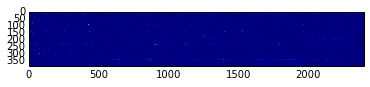

In [112]:
plt.imshow(features.T)

In [115]:
import sklearn.preprocessing
import sklearn.tree
import sklearn.svm
import sklearn.multiclass
import sklearn.ensemble
import sklearn.cross_validation


all_ylabels = dmoz_data['topics']
import itertools
import collections
counts = collections.Counter(itertools.chain.from_iterable(all_ylabels))
uncommon = [x for x in counts if counts[x] < 9]
ylabels = np.array([[i for i in l if i not in uncommon] for l in all_ylabels])

#if len(ylabels.shape) == 1:
if False:
    label_processor = sklearn.preprocessing.LabelEncoder()
else:
    label_processor = sklearn.preprocessing.MultiLabelBinarizer()

label_processor.fit(ylabels)
#clf = sklearn.tree.DecisionTreeClassifier(random_state=0)
clf = sklearn.ensemble.ExtraTreesClassifier(random_state=0, n_estimators=100, oob_score=True, bootstrap=True, n_jobs=4)
X = features[:,np.sum(features > 0, axis=0)>0]
#X = np.random.rand(X.shape[0], X.shape[1])
y = label_processor.transform(ylabels)
print sklearn.cross_validation.cross_val_score(clf, X, y)


[ 0.00125     0.01376721  0.00125156]


In [ ]:
label_processor.transform(ylabels[1:4])

In [ ]:
ylabels[1:40]

In [ ]:
ylabels[100]

In [ ]:
test = sklearn.preprocessing.MultiLabelBinarizer().fit(ylabels)
print test.transform(ylabels[1])
print test.inverse_transform(test.transform([ylabels[0]]))


In [75]:
#zip(clf.transform(X)[0][np.where(clf.transform(X)[0]>0)], ylabels[np.where(clf.transform(X)[0]>0)])
clf.fit(X, y)

ExtraTreesClassifier(bootstrap=True, compute_importances=None,
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=4, oob_score=True,
           random_state=0, verbose=0)

In [77]:
meta[0:10]

[(u'http://www.siliconcoach.com/', [u'sports', u'software']),
 (u'http://www.recenroll.com/', [u'sports', u'software']),
 (u'http://www.gametime.net/', [u'sports', u'software']),
 (u'http://www.foxsportspulse.com/', [u'sports', u'software']),
 (u'http://www.crosstrainer.ca/', [u'sports', u'software']),
 (u'http://www.integratedsports.net/', [u'sports', u'software']),
 (u'http://www.sporting-heroes.net/', [u'sports', u'people']),
 (u'http://coedjewishsports.org/', [u'sports', u'organizations']),
 (u'http://www.sportandrecreation.org.uk', [u'sports', u'organizations']),
 (u'http://www.eis2win.co.uk/pages/default.aspx',
  [u'sports', u'organizations'])]

In [76]:
from pprint import pprint
pprint(label_processor.inverse_transform(clf.predict(X[0:10])))


[(u'software', u'sports'),
 (u'software', u'sports'),
 (u'software', u'sports'),
 (u'software', u'sports'),
 (u'software', u'sports'),
 (u'software', u'sports'),
 (u'people', u'sports'),
 (u'organizations', u'sports'),
 (u'organizations', u'sports'),
 (u'organizations', u'sports')]


In [16]:
X_train, X_test, y_train, y_test, ylabels_train, ylabels_test, meta_train, meta_test, ind_train, ind_test = sklearn.cross_validation.train_test_split(X, y, ylabels, meta, range(len(y)))
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

derp1 = np.array([t[0] for t in meta_test])[:15]
derp2 = dv.inverse_transform(pred)[:15]
derp3 = np.array([t[0] for t in meta_test])[:15]

#print np.vstack(()).T
#print ylabels[testnum]


NameError: name 'dv' is not defined

In [ ]:
print meta[897]
print [dictionary[x[0]] for x in corpus[897]]

In [ ]:
print dv.inverse_transform(pred)
print ylabels[testnum]

In [ ]:
' '.join(dictionary[w] for w, f in corpus[site])

In [ ]:
hdpmodel = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=dictionary)

In [ ]:
hdpmodel[corpus[5]]

In [ ]:
hdptops = hdpmodel.show_topics()
[x[0] for x in hdpmodel[corpus[5]]]

In [ ]:
hdptops[8]


In [ ]:
hdpmodel.m_eta + hdpmodel.m_lambda
hdpmodel.id2word